In [1]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import pandas as pd
import os
from catboost import CatBoostRegressor

In [8]:
def remove_correlated_features(df: pd.DataFrame, threshold: float = 0.8) -> pd.DataFrame:
    """
    Убирает из DataFrame столбцы, у которых абсолютная корреляция больше заданного порога.

    Аргументы:
    df -- входной pandas DataFrame
    threshold -- порог корреляции (по умолчанию 0.8)

    Возвращает:
    DataFrame без сильно скоррелированных признаков.
    """
    # Вычисляем корреляционную матрицу
    corr_matrix = df.corr().abs()

    # Создаем маску для верхнего треугольника матрицы (чтобы не учитывать дубли)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Находим столбцы, корреляция которых с любым другим столбцом выше threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Убираем эти столбцы из DataFrame
    df_reduced = df.drop(columns=to_drop)
    return df_reduced

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [ ]:
y = df['Crop prod']
X = df.drop(columns=['Crop prod'])


X_enc = X.copy()
from sklearn.preprocessing import LabelEncoder
for c in X_enc.select_dtypes(include=['object', 'category']):
    X_enc[c] = LabelEncoder().fit_transform(X_enc[c].astype(str))

In [20]:
print(X_enc.columns)

Index(['thermo_min', 'thermo_max', 'thermo_mean', 'thermo_stDev',
       'Field_BaseName', 'thermal_integral', 'ndsi_min', 'ndsi_max',
       'ndsi_mean', 'ndsi_stDev',
       ...
       'Department No.', 'Crop type', 'Variety', 'Reproduction', 'Sown Area',
       'Previous Crop', 'Primary Tillage Method', 'Seeder Brand',
       'Harvested Area', 'year'],
      dtype='object', length=137)


In [18]:
X_without_corr = remove_correlated_features(X_enc.copy(), 0.9)
print(X_without_corr.columns)

Index(['thermo_min', 'thermo_max', 'thermo_mean', 'thermo_stDev',
       'Field_BaseName', 'ndsi_min', 'ndsi_max', 'ndsi_mean', 'ndsi_stDev',
       'ndwi_max', 'ndwi_mean', 'ndwi_stDev', 'ndmi_min', 'ndmi_max',
       'ndmi_mean', 'ndmi_stDev', 'ndvi_min', 'ndvi_max', 'ndvi_mean',
       'ndvi_stDev', 'et0_fao_evapotranspiration', 'wind_speed_10m_max',
       'wind_gusts_10m_max', 'daylight_duration', 'wind_speed_10m_min',
       'wind_speed_10m_mean', 'wind_gusts_10m_mean', 'surface_pressure_max',
       'pressure_msl_max', 'soil_moisture_7_to_28cm_mean', 'dew_point_2m_min',
       'soil_moisture_100_to_255cm__aggr_mean', 'cloud_cover_high__aggr_mean',
       'is_day__aggr_mean', 'diffuse_radiation__aggr_mean',
       'terrestrial_radiation__aggr_mean', 'Department No.', 'Crop type',
       'Variety', 'Reproduction', 'Sown Area', 'Previous Crop',
       'Primary Tillage Method', 'Seeder Brand'],
      dtype='object')


In [16]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enc.copy())

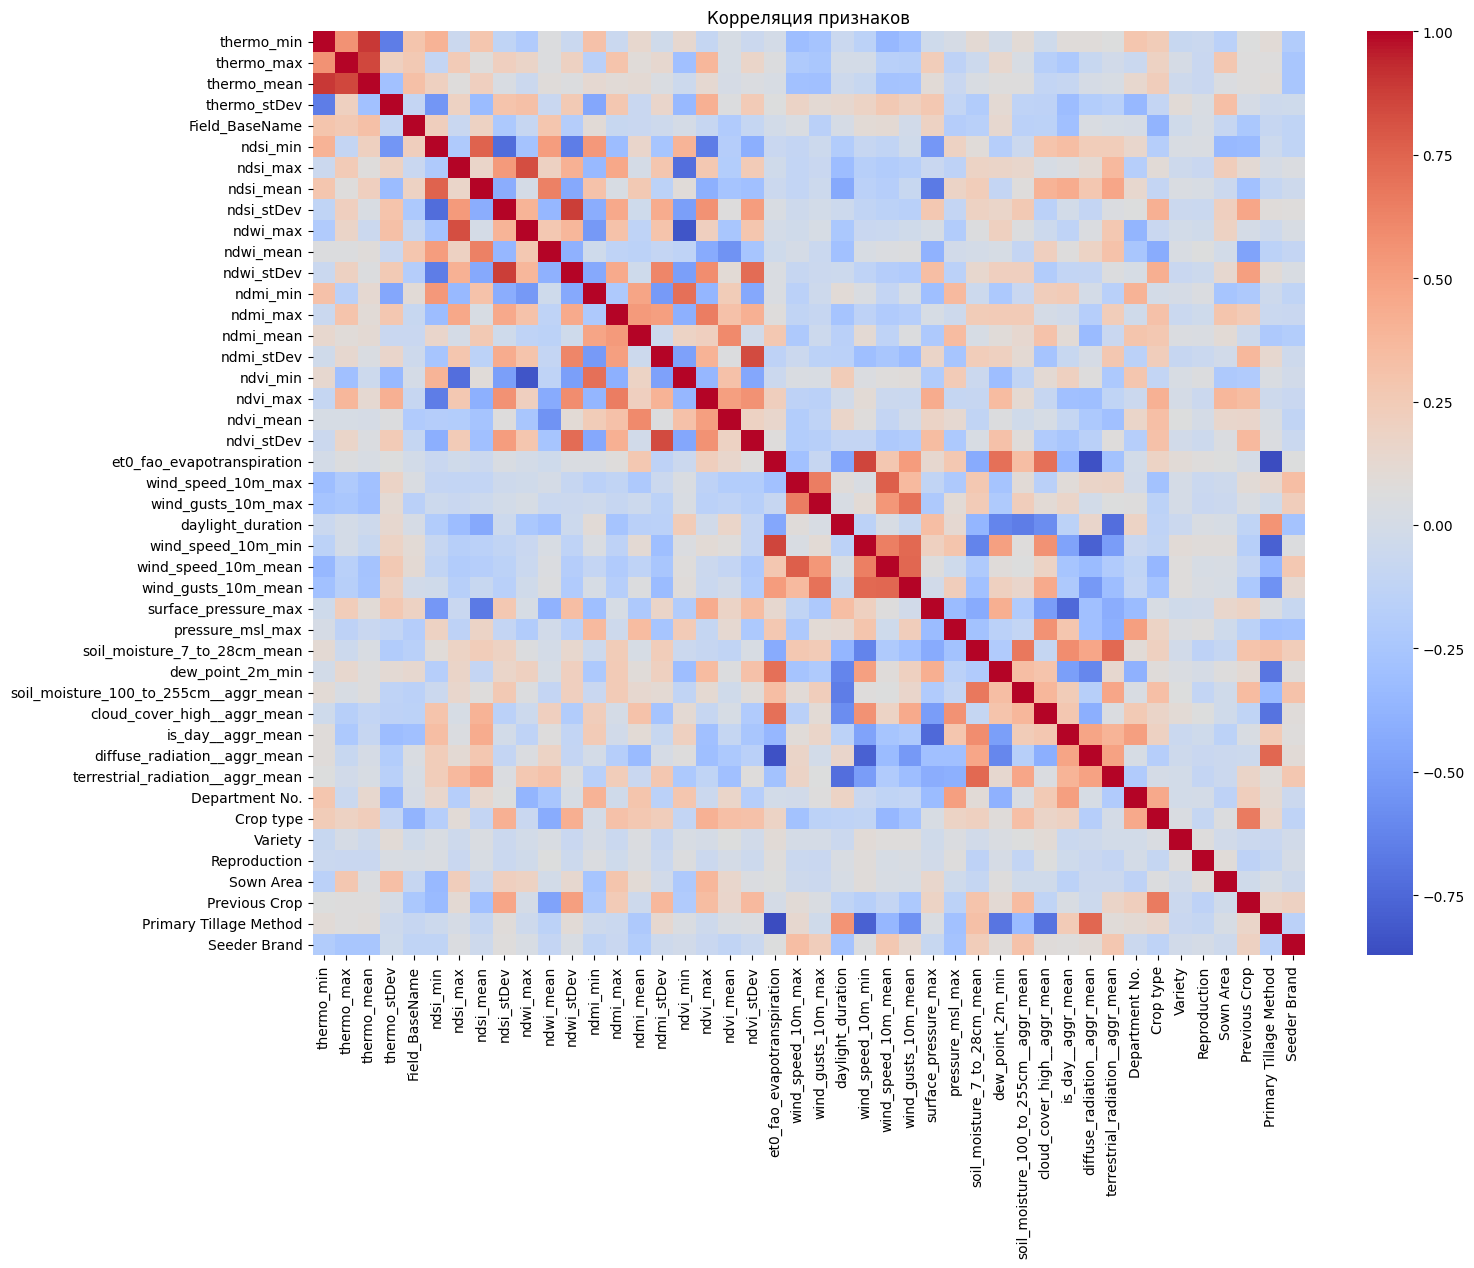

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))
sns.heatmap(X_without_corr.corr(), annot=False, cmap='coolwarm')
plt.title('Корреляция признаков')
plt.show()

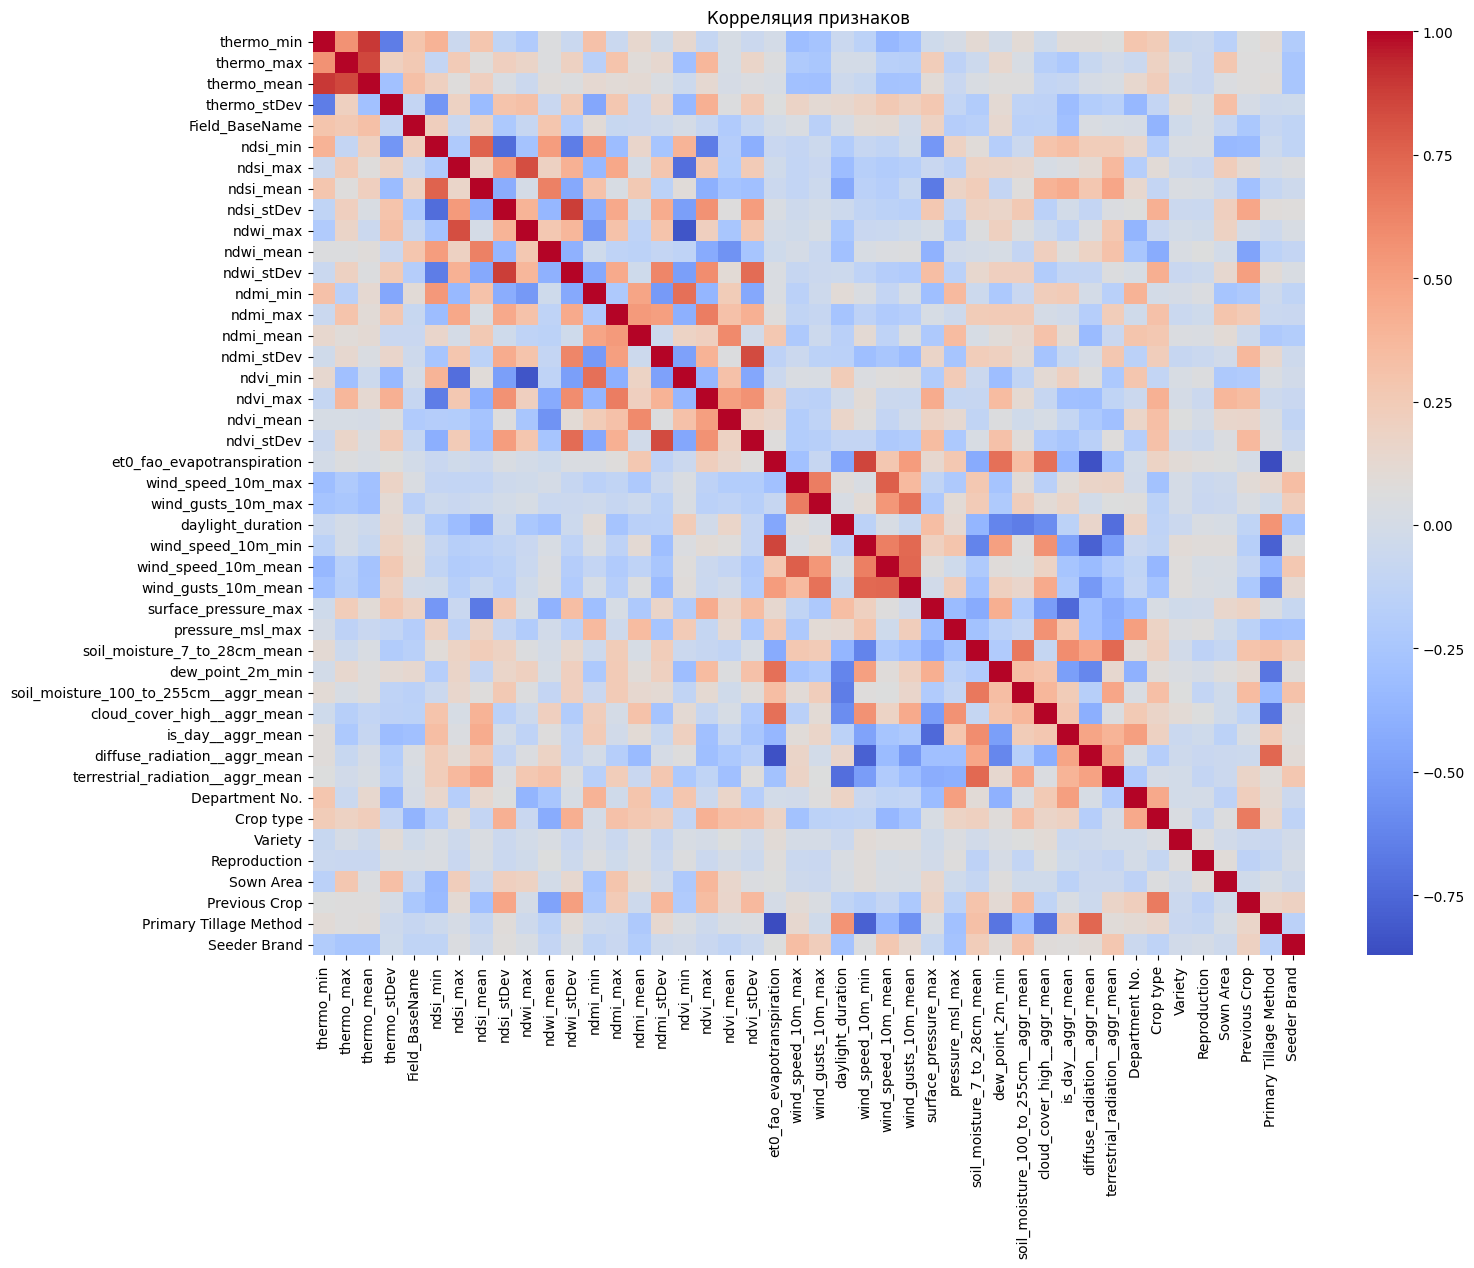

In [26]:
plt.figure(figsize=(16, 12))
sns.heatmap(corr_sub, annot=False, cmap='coolwarm')
plt.title('Корреляция признаков')
plt.show()

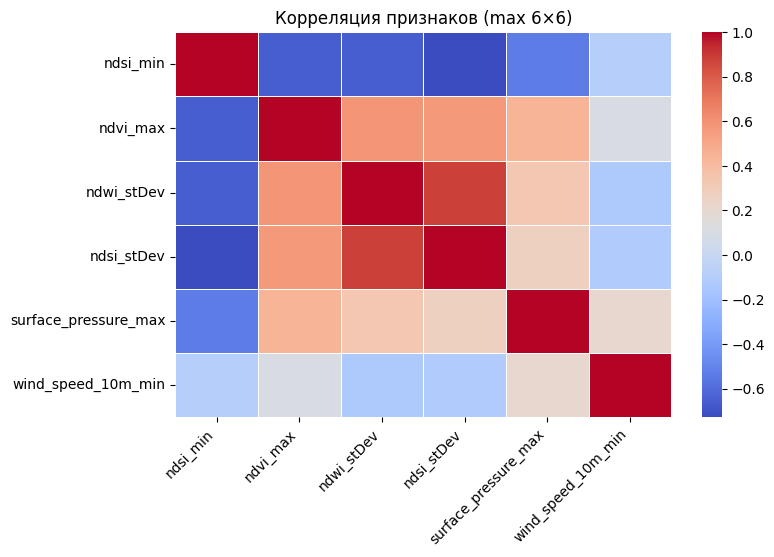

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ваша исходная матрица корреляций
# corr_sub = ...

# Задаём предел по осям
k = 6  # не более 20 признаков на каждой оси

# Если признаков больше, чем k, выбираем top-k по сумме абсолютных корреляций
if corr_sub.shape[0] > k:
    # считаем «силу» каждого признака
    strength = corr_sub.abs().sum(axis=1)
    # берём имена k самых «сильных»
    topk = strength.nlargest(k).index
    # обрезаем матрицу
    corr_plot = corr_sub.loc[topk, topk]
else:
    corr_plot = corr_sub.copy()

# Рисуем теплокарту
plt.figure(figsize=(8, 5))
sns.heatmap(
    corr_plot,
    annot=False,
    cmap='coolwarm',
    linewidths=0.5,
    #cbar_kws={'shrink': .8}
)
plt.title(f'Корреляция признаков (max {k}×{k})')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
#plt.tight_layout()
plt.show()


In [43]:
print(corr_plot.to_string(float_format="{:0.3f}".format))

                      ndsi_min  ndvi_max  ndwi_stDev  ndsi_stDev  surface_pressure_max  wind_speed_10m_min
ndsi_min                 1.000    -0.658      -0.657      -0.728                -0.535              -0.088
ndvi_max                -0.658     1.000       0.584       0.564                 0.441               0.106
ndwi_stDev              -0.657     0.584       1.000       0.883                 0.337              -0.133
ndsi_stDev              -0.728     0.564       0.883       1.000                 0.269              -0.118
surface_pressure_max    -0.535     0.441       0.337       0.269                 1.000               0.210
wind_speed_10m_min      -0.088     0.106      -0.133      -0.118                 0.210               1.000


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

X_cv = X_scaled.copy()
y_cv = y.to_numpy().copy()

# Создаем KFold объект
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Список моделей для проверки
models = [
    'Linear Regression',
    'Ridge',
    'Knn',
    'Random Forest',
    'CatBoost',
    'Xgboost',
    'Lightgbm']

# Ручная кросс-валидация
for model_name in models:
    print(f"\n=== {model_name} Cross-Validation ===")
    
    rmse_scores = []
    mae_scores = []
    r2_scores = []

    model = None
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_cv, y_cv)):
        X_fold_train, y_fold_train = X_cv[train_idx], y_cv[train_idx]
        X_fold_val, y_fold_val = X_cv[val_idx], y_cv[val_idx]
        
        # Особый случай для CatBoost

        if model_name == 'Linear Regression': model = LinearRegression()
        elif model_name == 'Ridge': model = Ridge()
        elif model_name == 'Knn': model = KNeighborsRegressor()
        elif model_name == 'Random Forest': model = RandomForestRegressor()
        elif model_name == 'CatBoost':
            model = CatBoostRegressor(random_state=42, verbose=0)
        elif model_name == 'Xgboost':
            model = XGBRegressor(random_state=42)
        elif model_name == 'Lightgbm':
            model = LGBMRegressor(random_state=42, verbose=-1)

        # Обучение модели
        if model_name == 'Xgboost':
            model.fit(X_fold_train, y_fold_train, verbose=False)
        elif model_name == 'Lightgbm':
            model.fit(X_fold_train, y_fold_train)
        else:
            model.fit(X_fold_train, y_fold_train)
        
        y_pred = model.predict(X_fold_val)
        
        # Расчет метрик
        fold_rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
        fold_mae = mean_absolute_error(y_fold_val, y_pred)
        fold_r2 = r2_score(y_fold_val, y_pred)
        
        rmse_scores.append(fold_rmse)
        r2_scores.append(fold_r2)
        mae_scores.append(fold_mae)
        
        print(f"Fold {fold+1}: RMSE={fold_rmse:.2f}, MAE={fold_mae:.2f}, R2={fold_r2:.2f}")
    
    # Агрегированные результаты
    print("\nAverage Scores:")
    print(f"RMSE: {np.mean(rmse_scores):.2f} (±{np.std(rmse_scores):.2f})")
    print(f"MAE: {np.mean(mae_scores):.2f} (±{np.std(mae_scores):.2f})")
    print(f"R2:  {np.mean(r2_scores):.2f} (±{np.std(r2_scores):.2f})")
    print("="*50)


=== Linear Regression Cross-Validation ===
Fold 1: RMSE=7.04, MAE=5.25, R2=0.14
Fold 2: RMSE=5.87, MAE=4.53, R2=0.24
Fold 3: RMSE=6.03, MAE=4.65, R2=0.35
Fold 4: RMSE=6.95, MAE=5.33, R2=0.21
Fold 5: RMSE=7.06, MAE=5.31, R2=0.05

Average Scores:
RMSE: 6.59 (±0.53)
MAE: 5.01 (±0.35)
R2:  0.20 (±0.10)

=== Ridge Cross-Validation ===
Fold 1: RMSE=6.63, MAE=4.96, R2=0.24
Fold 2: RMSE=5.80, MAE=4.47, R2=0.26
Fold 3: RMSE=6.00, MAE=4.50, R2=0.35
Fold 4: RMSE=6.49, MAE=4.85, R2=0.31
Fold 5: RMSE=5.95, MAE=4.35, R2=0.32

Average Scores:
RMSE: 6.17 (±0.33)
MAE: 4.63 (±0.24)
R2:  0.30 (±0.04)

=== Knn Cross-Validation ===
Fold 1: RMSE=6.05, MAE=4.25, R2=0.37
Fold 2: RMSE=5.18, MAE=3.84, R2=0.41
Fold 3: RMSE=5.97, MAE=4.39, R2=0.36
Fold 4: RMSE=5.87, MAE=4.11, R2=0.44
Fold 5: RMSE=6.80, MAE=4.56, R2=0.12

Average Scores:
RMSE: 5.98 (±0.51)
MAE: 4.23 (±0.24)
R2:  0.34 (±0.11)

=== Random Forest Cross-Validation ===
Fold 1: RMSE=4.89, MAE=3.19, R2=0.59
Fold 2: RMSE=4.04, MAE=2.65, R2=0.64
Fold 3: R

c:\Users\rugiv\anaconda3\envs\cv-task\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 1: RMSE=4.83, MAE=2.91, R2=0.60


c:\Users\rugiv\anaconda3\envs\cv-task\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 2: RMSE=3.65, MAE=2.35, R2=0.71


c:\Users\rugiv\anaconda3\envs\cv-task\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 3: RMSE=4.31, MAE=2.84, R2=0.67


c:\Users\rugiv\anaconda3\envs\cv-task\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 4: RMSE=4.77, MAE=2.81, R2=0.63
Fold 5: RMSE=4.98, MAE=3.03, R2=0.53

Average Scores:
RMSE: 4.51 (±0.49)
MAE: 2.79 (±0.23)
R2:  0.63 (±0.06)


c:\Users\rugiv\anaconda3\envs\cv-task\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
from catboost import Pool

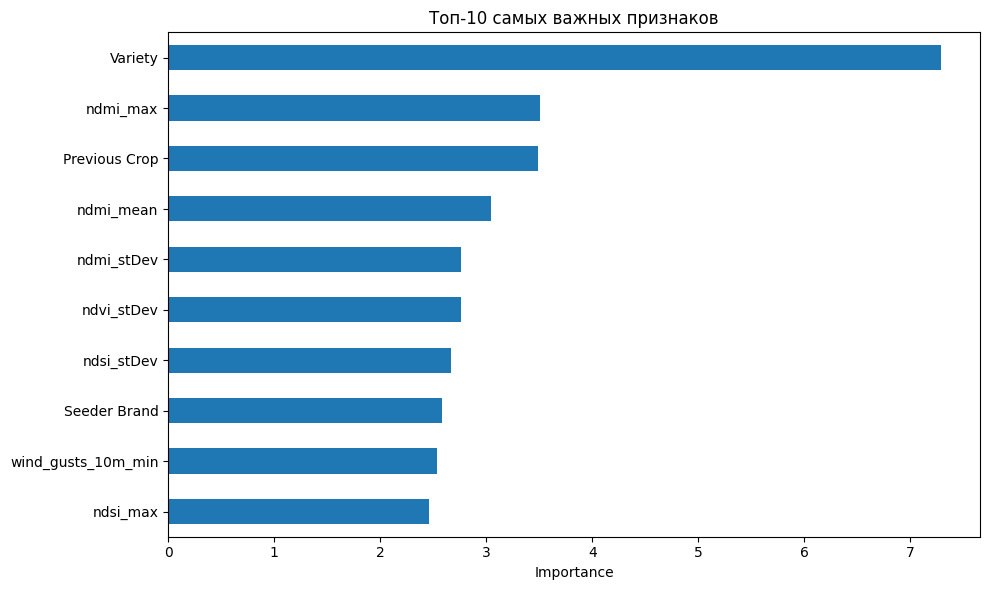

In [ ]:
X_for_feat = X_enc.copy()
X_for_feat = X_for_feat.drop(['Harvested Area', 'Sown Area'], axis=1)

# Обучаем модель
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(X_for_feat, y.to_numpy().copy())

# Получаем важности
pool = Pool(X_for_feat, y.to_numpy().copy())
importances = model.get_feature_importance(pool, type='FeatureImportance')

# Собираем в Series и отбираем топ-10
fi = pd.Series(importances, index=X_for_feat.columns)
top10 = fi.sort_values(ascending=False).head(10)

# Строим график (от самых менее важных в топ-10 к самым важным для удобства чтения)
plt.figure(figsize=(10, 6))
top10.sort_values().plot(kind='barh')
plt.title('Топ-10 самых важных признаков')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()